# Technical Assesment
###### Britton Blaize Olle

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import statsmodels.api as sm
import csv
import math
import sklearn
from scipy.optimize import minimize
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
import json
import seaborn as sns

C:\Users\blaiz\Documents\Python\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\Users\blaiz\Documents\Python\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Wrangle Data
Pull the data with the appropriate columns.
However, I do think there could have been some other columns that would have been useful for this analysis. Particularly the 'id', and 'home_owner' which I think would be an additional variable that could be fun to look at.

In [2]:
loan_main = pd.read_csv("loan.csv", usecols=['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'grade', 'annual_inc', 'issue_d',
                                             'dti', 'revol_bal', 'total_pymnt', 'loan_status'])

In [3]:
loan_main.head()

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,loan_status,dti,revol_bal,total_pymnt
0,5000.0,5000.0,36 months,10.65,B,24000.0,Dec-2011,Fully Paid,27.65,13648.0,5861.071414
1,2500.0,2500.0,60 months,15.27,C,30000.0,Dec-2011,Charged Off,1.00,1687.0,1008.710000
2,2400.0,2400.0,36 months,15.96,C,12252.0,Dec-2011,Fully Paid,8.72,2956.0,3003.653644
3,10000.0,10000.0,36 months,13.49,C,49200.0,Dec-2011,Fully Paid,20.00,5598.0,12226.302212
4,3000.0,3000.0,60 months,12.69,B,80000.0,Dec-2011,Current,17.94,27783.0,3242.170000


###### Initial lookup

In [4]:
print(loan_main.shape)

(887379, 11)


In [5]:
loan_main.isnull().sum()

loan_amnt      0
funded_amnt    0
term           0
int_rate       0
grade          0
annual_inc     4
issue_d        0
loan_status    0
dti            0
revol_bal      0
total_pymnt    0
dtype: int64

The data set we will be working with is limited to the 11 variables specified in the PDF with 887,379 observations with only 4 apparent null variables all within the annual_income category. For simplicity, to fix this issue for now I am going to fill the NA variables with the next available value. However, given more time I think a more appropriate solution would be to find the distribution of annual income for each grade of loan and randomly pick from the distribution to fill the missing values. But do to time constraints and the fact that only 4 values are missing, the median fill should be sufficient. Additionally, because of the small portion of Na values I also think it would be acceptable to drop the loans with NA values completely. Currently there is no index I will be grouping the data and changing the index throughout the analysis. To start I will use the issued date as index.

In [6]:
loan_main=loan_main.fillna(method='ffill').fillna(method='bfill')
loan_main.isnull().sum()

loan_amnt      0
funded_amnt    0
term           0
int_rate       0
grade          0
annual_inc     0
issue_d        0
loan_status    0
dti            0
revol_bal      0
total_pymnt    0
dtype: int64

In [7]:
print(loan_main.duplicated().sum())
#No duplicates

0


In [8]:
pvt=loan_main.set_index(['issue_d'])
pvt.head()

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,loan_status,dti,revol_bal,total_pymnt
issue_d,,,,,,,,,,
Dec-2011,5000.0,5000.0,36 months,10.65,B,24000.0,Fully Paid,27.65,13648.0,5861.071414
Dec-2011,2500.0,2500.0,60 months,15.27,C,30000.0,Charged Off,1.00,1687.0,1008.710000
Dec-2011,2400.0,2400.0,36 months,15.96,C,12252.0,Fully Paid,8.72,2956.0,3003.653644
Dec-2011,10000.0,10000.0,36 months,13.49,C,49200.0,Fully Paid,20.00,5598.0,12226.302212
Dec-2011,3000.0,3000.0,60 months,12.69,B,80000.0,Current,17.94,27783.0,3242.170000


Next, we will do exploration. First, I am interested to see uniquids for the variables 'term', 'loan_status'. Below you can see the variables.

In [9]:
print(pvt['term'].unique())
print(pvt['grade'].unique())
print(pvt['loan_status'].unique())

[' 36 months' ' 60 months']
['B' 'C' 'A' 'E' 'F' 'D' 'G']
['Fully Paid' 'Charged Off' 'Current' 'Default' 'Late (31-120 days)'
 'In Grace Period' 'Late (16-30 days)'
 'Does not meet the credit policy. Status:Fully Paid'
 'Does not meet the credit policy. Status:Charged Off' 'Issued']


I think, especially for the grades it could be useful to create some dummy variables which I will do later.
Additionally, I am switching back to having no index.
###### Summary statistics and Distribution of Graphs.
To avoid biases created by outliers I think it is important to use the median instead of the mean for the general statistics. While I do analyze the mean, for distributions and analysis I will use the median statistics.

In [10]:
loan_main.groupby('grade').median()

,loan_amnt,funded_amnt,int_rate,annual_inc,dti,revol_bal,total_pymnt
grade,,,,,,,
A,12000.0,12000.0,7.26,75000.0,15.080,12866.0,4808.390
B,12000.0,12000.0,10.99,65000.0,16.860,11879.0,4915.490
C,12000.0,12000.0,13.99,60000.0,18.350,11563.0,4521.880
D,14000.0,14000.0,16.99,60000.0,19.450,11304.0,5114.575
E,16850.0,16800.0,19.99,61000.0,20.050,12155.0,5169.230
F,18625.0,18550.0,23.76,65000.0,19.695,12022.5,6491.285
G,20000.0,20000.0,25.83,68000.0,19.280,11553.0,8186.450


In [11]:
loan_main.groupby('grade').mean()

,loan_amnt,funded_amnt,int_rate,annual_inc,dti,revol_bal,total_pymnt
grade,,,,,,,
A,14038.860306,14023.323572,7.243312,86941.890728,15.577401,18953.963199,7068.284092
B,13642.965211,13630.195062,10.829618,75487.389207,17.305115,16911.403017,7266.042944
C,14466.306028,14458.230599,13.980098,71536.950300,18.792559,16355.232405,7175.405419
D,15459.506278,15450.499670,17.175814,69169.272616,19.908175,15880.873551,7922.393262
E,17998.146171,17970.831978,19.897322,72119.152229,20.338847,16847.066077,8862.453019
F,19139.160809,19098.808904,23.582787,73801.170917,19.834316,16410.247158,10718.213782
G,20538.563491,20497.959555,25.626706,79904.591762,19.182093,17322.579705,12254.420001


In [12]:
loan_main.groupby('grade').min().head()

,loan_amnt,funded_amnt,term,int_rate,annual_inc,issue_d,loan_status,dti,revol_bal,total_pymnt
grade,,,,,,,,,,
A,500.0,500.0,36 months,5.32,3300.0,Apr-2008,Charged Off,0.0,0.0,0.0
B,500.0,500.0,36 months,6.00,2000.0,Apr-2008,Charged Off,0.0,0.0,0.0
C,500.0,500.0,36 months,6.00,0.0,Apr-2008,Charged Off,0.0,0.0,0.0
D,500.0,500.0,36 months,6.00,0.0,Apr-2008,Charged Off,0.0,0.0,0.0
E,600.0,600.0,36 months,6.00,1200.0,Apr-2008,Charged Off,0.0,0.0,0.0


In [13]:
loan_main.groupby('grade').max().head()

,loan_amnt,funded_amnt,term,int_rate,annual_inc,issue_d,loan_status,dti,revol_bal,total_pymnt
grade,,,,,,,,,,
A,35000.0,35000.0,60 months,9.63,9500000.0,Sep-2015,Late (31-120 days),39.99,2568995.0,40126.176367
B,35000.0,35000.0,60 months,14.09,8700000.0,Sep-2015,Late (31-120 days),41.69,1743266.0,46763.187147
C,35000.0,35000.0,60 months,17.27,8706582.0,Sep-2015,Late (31-120 days),9999.00,1746716.0,49015.689950
D,35000.0,35000.0,60 months,20.31,8900060.0,Sep-2015,Late (31-120 days),9999.00,2904836.0,51921.657702
E,35000.0,35000.0,60 months,23.40,7500000.0,Sep-2015,Late (31-120 days),672.52,1030826.0,54329.489934


In [14]:
Table_summary=loan_main.describe()
Table_summary

,loan_amnt,funded_amnt,int_rate,annual_inc,dti,revol_bal,total_pymnt
count,887379.000000,887379.000000,887379.000000,8.873790e+05,887379.000000,8.873790e+05,887379.000000
mean,14755.264605,14741.877625,13.246740,7.502751e+04,18.157039,1.692079e+04,7558.826684
std,8435.455601,8429.897657,4.381867,6.469819e+04,17.190626,2.242679e+04,7871.243336
min,500.000000,500.000000,5.320000,0.000000e+00,0.000000,0.000000e+00,0.000000
25%,8000.000000,8000.000000,9.990000,4.500000e+04,11.910000,6.443000e+03,1914.590000
50%,13000.000000,13000.000000,12.990000,6.500000e+04,17.650000,1.187500e+04,4894.999117
75%,20000.000000,20000.000000,16.200000,9.000000e+04,23.950000,2.082900e+04,10616.814231
max,35000.000000,35000.000000,28.990000,9.500000e+06,9999.000000,2.904836e+06,57777.579870


###### Distributions
Next let’s look at some important distributions. Starting first with interest rates. To avoid biases created by outliers I think it is important to use the median instead of the mean for the general statistics. While I do analyze the mean, for distributions and analysis I will use the median statistics.


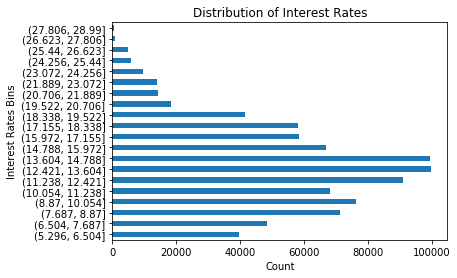

In [15]:
zzz=pd.cut(loan_main['int_rate'].values,bins=20).value_counts().plot(kind='barh')
plt.title('Distribution of Interest Rates')
plt.xlabel('Count')
plt.ylabel('Interest Rates Bins')
plt.show()

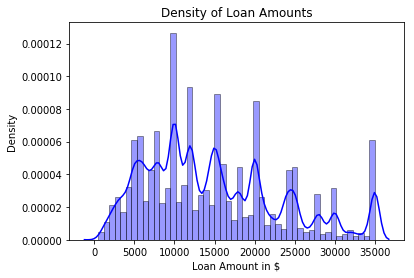

In [16]:
# seaborn histogram
sns.distplot(loan_main['loan_amnt'], hist=True, kde=True, color = 'blue', hist_kws={'edgecolor':'black'})
# Add labels

plt.title('Density of Loan Amounts')
plt.xlabel('Loan Amount in $')
plt.ylabel('Density')
plt.show()

In the plot above we see a variable distribution. It illustrates an almost lognormal type distribution with massive spikes at specific points. We can see these spikes tend to happen in intervals of 5,000.

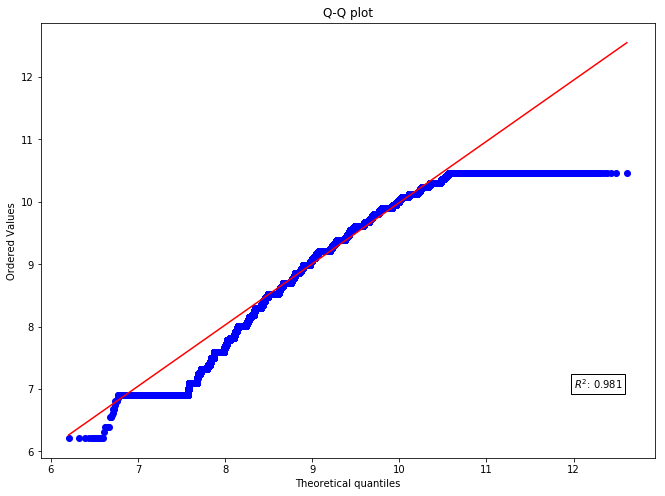

In [17]:
import matplotlib.pyplot as plt
import scipy.stats as sp

def qq_plot(series, figsize=(11, 8)):
    """compare given series to Normal distirbution
    with matching location & scale"""
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    arrs, res = sp.probplot(series, 
                            dist=sp.norm, 
                            sparams=(series.mean(), series.std()), 
                            plot=ax)
    bbox = {'fc': '1', 'pad': 3}
    xy = (ax.get_xticks()[-2], ax.get_yticks()[2])
    text = ax.annotate(r'$R^2$: {}'.format(round(res[2], 3)),
                     xy=xy,
                     bbox=bbox)
    title = ax.set_title('Q-Q plot')
qq_plot(np.log(pvt['loan_amnt']), figsize=(11,8))
plt.show()

# Part 2
The goal is to see if we can accurately predict default rates of 36 term month loans.
So first I will remove all 60 month term loans and take out all loans with less than 36 months to maturity.
###### Adjust data set

In [18]:
print(pvt['term'].unique())

[' 36 months' ' 60 months']


In [19]:
loan_main=loan_main[loan_main.term != ' 60 months']
loan_main['term'].unique()

array([' 36 months'], dtype=object)

The data is from 2007-2015 are months that will not be included are loans that were issued less than 36 months prior to Dec-2015

In [20]:
loan_main.issue_d=pd.to_datetime(loan_main['issue_d'])

In [21]:
first_date=dt.date(2012,12,31)
loan_main=loan_main[loan_main.issue_d < first_date]
loan_main['issue_d'].unique()

array(['2011-12-01T00:00:00.000000000', '2011-11-01T00:00:00.000000000',
       '2011-10-01T00:00:00.000000000', '2011-09-01T00:00:00.000000000',
       '2011-08-01T00:00:00.000000000', '2011-07-01T00:00:00.000000000',
       '2011-06-01T00:00:00.000000000', '2011-05-01T00:00:00.000000000',
       '2011-04-01T00:00:00.000000000', '2011-03-01T00:00:00.000000000',
       '2011-02-01T00:00:00.000000000', '2011-01-01T00:00:00.000000000',
       '2010-12-01T00:00:00.000000000', '2010-11-01T00:00:00.000000000',
       '2010-10-01T00:00:00.000000000', '2010-09-01T00:00:00.000000000',
       '2010-08-01T00:00:00.000000000', '2010-07-01T00:00:00.000000000',
       '2010-06-01T00:00:00.000000000', '2010-05-01T00:00:00.000000000',
       '2010-04-01T00:00:00.000000000', '2010-03-01T00:00:00.000000000',
       '2010-02-01T00:00:00.000000000', '2010-01-01T00:00:00.000000000',
       '2009-12-01T00:00:00.000000000', '2009-11-01T00:00:00.000000000',
       '2009-10-01T00:00:00.000000000', '2009-09-01

In [22]:
loan_main.head()

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,loan_status,dti,revol_bal,total_pymnt
0,5000.0,5000.0,36 months,10.65,B,24000.0,2011-12-01,Fully Paid,27.65,13648.0,5861.071414
2,2400.0,2400.0,36 months,15.96,C,12252.0,2011-12-01,Fully Paid,8.72,2956.0,3003.653644
3,10000.0,10000.0,36 months,13.49,C,49200.0,2011-12-01,Fully Paid,20.00,5598.0,12226.302212
5,5000.0,5000.0,36 months,7.90,A,36000.0,2011-12-01,Fully Paid,11.20,7963.0,5631.377753
7,3000.0,3000.0,36 months,18.64,E,48000.0,2011-12-01,Fully Paid,5.35,8221.0,3938.144334


###### 1) What percentage of loans has been fully paid? 

In [23]:
print(pvt['loan_status'].unique())


['Fully Paid' 'Charged Off' 'Current' 'Default' 'Late (31-120 days)'
 'In Grace Period' 'Late (16-30 days)'
 'Does not meet the credit policy. Status:Fully Paid'
 'Does not meet the credit policy. Status:Charged Off' 'Issued']


In [24]:
x1=pd.get_dummies(loan_main['loan_status'], drop_first=False)
print(x1['Fully Paid'].value_counts())
print(x1['Fully Paid'].value_counts()[1]/(x1['Fully Paid'].value_counts()[0]+x1['Fully Paid'].value_counts()[1]))

1    63357
0    11647
Name: Fully Paid, dtype: int64
0.844714948536


84.447% of loans have been fully paid off.

###### 2) When bucketed by year of origination and grade, which cohort has the highest rate of defaults? 
Here you may assume that any loan which was not fully paid had “defaulted”.

In [25]:
paid = {'Fully Paid'}
loan_main['default'] = loan_main.loan_status.apply(lambda x: 0 if x in paid else 1)
loan_main['total'] = loan_main.loan_status.apply(lambda x: 1 if x in paid else 1)
loan_main.head()

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,loan_status,dti,revol_bal,total_pymnt,default,total
0,5000.0,5000.0,36 months,10.65,B,24000.0,2011-12-01,Fully Paid,27.65,13648.0,5861.071414,0,1
2,2400.0,2400.0,36 months,15.96,C,12252.0,2011-12-01,Fully Paid,8.72,2956.0,3003.653644,0,1
3,10000.0,10000.0,36 months,13.49,C,49200.0,2011-12-01,Fully Paid,20.00,5598.0,12226.302212,0,1
5,5000.0,5000.0,36 months,7.90,A,36000.0,2011-12-01,Fully Paid,11.20,7963.0,5631.377753,0,1
7,3000.0,3000.0,36 months,18.64,E,48000.0,2011-12-01,Fully Paid,5.35,8221.0,3938.144334,0,1


In [26]:
x=loan_main.groupby(['issue_d', 'grade']).sum().sort_values('default', ascending=False)
x['pct_default']=x['default']/x['total']
x.sort_values('default', ascending=False).head()

,,loan_amnt,funded_amnt,int_rate,annual_inc,dti,revol_bal,total_pymnt,default,total,pct_default
issue_d,grade,,,,,,,,,,
2012-11-01,B,22353450.0,22353450.0,25637.23,1.356026e+08,37395.24,31298829.0,2.471654e+07,257,2081,0.123498
2012-09-01,B,21756250.0,21756250.0,25597.30,1.256999e+08,36446.75,28945702.0,2.406466e+07,254,2077,0.122292
2012-10-01,B,22176100.0,22176100.0,26556.01,1.268039e+08,39097.67,28921118.0,2.453530e+07,253,2166,0.116805
2012-08-01,B,18006075.0,18006075.0,21248.17,1.065109e+08,30629.33,23147811.0,1.979213e+07,230,1722,0.133566
2012-11-01,C,15105900.0,15105900.0,20189.63,8.868590e+07,23670.15,19607757.0,1.696147e+07,216,1308,0.165138


In [27]:
x.sort_values('pct_default', ascending=False).head()

,,loan_amnt,funded_amnt,int_rate,annual_inc,dti,revol_bal,total_pymnt,default,total,pct_default
issue_d,grade,,,,,,,,,,
2007-06-01,C,32850.0,32850.0,65.44,360000.0,64.52,13660.0,37288.66,6,6,1.0
2007-12-01,G,98375.0,89975.0,138.61,713000.0,174.64,205744.0,97984.24,8,8,1.0
2011-04-01,G,54000.0,54000.0,40.59,160000.0,30.53,54915.0,21916.79,2,2,1.0
2008-09-01,E,45000.0,42400.0,150.02,605981.2,177.85,194453.0,43470.81,10,10,1.0
2008-11-01,G,36500.0,36500.0,37.76,183000.0,25.64,36918.0,16653.16,2,2,1.0


The bucketed group with the most defaults is loans issued on November-2012 with a grade of B.
However, there are some groups of loans that had a 100% default rate as is illustrated above.

The Bucketed group with the most defaults is loans issued on Oct-2015 with a grade of B. This is interesting because if you look at the loans with the least amount of default you see that they were all issued in 2008 after crisis happened. So, it appears timing has a massive effect on loan default.

###### 3) When bucketed by year of origination and grade, what annualized rate of return have these loans generated on average?
For simplicity, use the following approximation:
Annualized rate of return = (total_pymnt / funded_amnt) ^ (1/3) - 1


In [28]:
paid = {'Fully Paid'}
loan_main['Ann_ret'] = (loan_main.total_pymnt / loan_main.funded_amnt)**(1/3)-1 
loan_main.head()

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,loan_status,dti,revol_bal,total_pymnt,default,total,Ann_ret
0,5000.0,5000.0,36 months,10.65,B,24000.0,2011-12-01,Fully Paid,27.65,13648.0,5861.071414,0,1,0.054393
2,2400.0,2400.0,36 months,15.96,C,12252.0,2011-12-01,Fully Paid,8.72,2956.0,3003.653644,0,1,0.077654
3,10000.0,10000.0,36 months,13.49,C,49200.0,2011-12-01,Fully Paid,20.00,5598.0,12226.302212,0,1,0.069297
5,5000.0,5000.0,36 months,7.90,A,36000.0,2011-12-01,Fully Paid,11.20,7963.0,5631.377753,0,1,0.040435
7,3000.0,3000.0,36 months,18.64,E,48000.0,2011-12-01,Fully Paid,5.35,8221.0,3938.144334,0,1,0.094940


In [29]:
loan_main.groupby(['issue_d', 'grade']).max().sort_values('Ann_ret', ascending=False).head()

,,loan_amnt,funded_amnt,term,int_rate,annual_inc,loan_status,dti,revol_bal,total_pymnt,default,total,Ann_ret
issue_d,grade,,,,,,,,,,,,
2007-12-01,G,25000.0,25000.0,36 months,17.86,350000.0,Does not meet the credit policy. Status:Fully ...,28.73,128850.0,39473.920000,1,1,0.164457
2010-03-01,D,25000.0,25000.0,36 months,16.07,340000.0,Fully Paid,24.99,287002.0,38057.783022,1,1,0.150362
2010-06-01,C,25000.0,23050.0,36 months,14.72,200000.0,Fully Paid,24.56,100671.0,28355.330000,1,1,0.133803
2011-09-01,G,22250.0,22250.0,36 months,23.22,95000.0,Fully Paid,21.47,18724.0,32103.000950,0,1,0.129983
2012-11-01,G,23275.0,23275.0,36 months,24.83,65000.0,Fully Paid,16.58,34001.0,33239.450120,0,1,0.126129


We find that G has the highest rate of returns on average. This makes sense because for the additional risk the investors are taking on they expect a higher return.

# Part 3
Logistic Regression

In [30]:
print(loan_main['default'].value_counts())
data=loan_main
print(data['default'].value_counts())

0    63357
1    11647
Name: default, dtype: int64
0    63357
1    11647
Name: default, dtype: int64


###### Creating Dummy Variables
First, I am going to create dummy variables for my categorical variables, excluding loan_status because that gives the default status implicitly. The variables that will be used are 'grade', 'term' and 'issue_d'. Each of these variables will be split into several different dummy variables, these dummy variables are what I will be using in my logistic regression. I dropped the first dummy variable of each new set because the first dummy variable is our base.

In [31]:
x1=pd.get_dummies(data['issue_d'], 'date', drop_first=True)
x2=pd.get_dummies(data['grade'], 'grade', drop_first=True)
x3=pd.get_dummies(data['term'], 'term', drop_first=True)
data=data.join(x1)
data=data.join(x2)
data=data.join(x3)

The goal is to try and create a model that accurately predicts default probability. First, we will assume we have all the data to date. The last step will be to remove all the data that we wouldn't have at the loan’s origins. 

For now we will simply remove the initial categorical data we created dummy variables for.

In [32]:
cat_vars=['issue_d','grade','term','loan_status', 'total']
data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]
data_final=data[to_keep]
data_final.columns.values

array(['loan_amnt', 'funded_amnt', 'int_rate', 'annual_inc', 'dti',
       'revol_bal', 'total_pymnt', 'default', 'Ann_ret',
       'date_2007-07-01 00:00:00', 'date_2007-08-01 00:00:00',
       'date_2007-09-01 00:00:00', 'date_2007-10-01 00:00:00',
       'date_2007-11-01 00:00:00', 'date_2007-12-01 00:00:00',
       'date_2008-01-01 00:00:00', 'date_2008-02-01 00:00:00',
       'date_2008-03-01 00:00:00', 'date_2008-04-01 00:00:00',
       'date_2008-05-01 00:00:00', 'date_2008-06-01 00:00:00',
       'date_2008-07-01 00:00:00', 'date_2008-08-01 00:00:00',
       'date_2008-09-01 00:00:00', 'date_2008-10-01 00:00:00',
       'date_2008-11-01 00:00:00', 'date_2008-12-01 00:00:00',
       'date_2009-01-01 00:00:00', 'date_2009-02-01 00:00:00',
       'date_2009-03-01 00:00:00', 'date_2009-04-01 00:00:00',
       'date_2009-05-01 00:00:00', 'date_2009-06-01 00:00:00',
       'date_2009-07-01 00:00:00', 'date_2009-08-01 00:00:00',
       'date_2009-09-01 00:00:00', 'date_2009-10-01 00:0

###### Split data
Next, we need to split the data into a training set and a testing set. The goal is to not over fit your model. If you test your data with the same data, you trained your model with then you are likely to get an overfitted model. By splitting the data, you can test your model without using any of the data points you used to test the model. I tend to like to train using 70%-80% of my data and testing with the remaining 20%-30%. 

In [33]:
X = data_final.loc[:, data_final.columns != 'default'].values
y = data_final.loc[:, data_final.columns == 'default'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=25)

In [34]:
LogReg = LogisticRegression()
LogReg.fit(X_train, np.concatenate(y_train))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

###### Test
After fitting the model, we can use our x variables from our test data to predict the expected outcome of our y variables.

In [35]:
y_pred = LogReg.predict(X_test)

Finally, we compare our predictions with the actual results. The matrix reports the results in the following way. The top left corner is the “True Positive”, meaning it is the number of times the model correctly guessed a default. The bottom left is “False Positives”, the number of times the model incorrectly predicted a default. The bottom right is “True Negatives” the number of times the model correctly predicted no default. The top right is, “False Negatives”, the number of times the model incorrectly predicted no default. 

In [36]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[18912    39]
 [ 1107  2444]]


Below is more measurement on the accuracy of our model. Precision is the ratio of the number of true positives and false positives.It determines how good the model is at not labeling a negative sample as positive. 
$$\frac{TP}{TP+FP}$$
Recall is the ratio of true positives to false negatives. It determines how good the model is at finding all positive samples.  
$$\frac{TP}{TP+FN}$$


In [37]:
print(sklearn.metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.94      1.00      0.97     18951
          1       0.98      0.69      0.81      3551

avg / total       0.95      0.95      0.95     22502



###### Results
From these results we can see that the model is very accurate. However, the model is limited in scope by its date specific variables. This essentially rendering it useless once these loans all expire.
##### Test
Let run the same regression without the date variables.

In [46]:
data2=loan_main
x2=pd.get_dummies(data2['grade'], 'grade', drop_first=True)
x3=pd.get_dummies(data2['term'], 'term', drop_first=True)
data2=data2.join(x2)
data2=data2.join(x3)

In [47]:
cat_vars=['issue_d','grade','term','loan_status', 'total']
data_vars=data2.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]
data_final=data2[to_keep]
data_final.columns.values

array(['loan_amnt', 'funded_amnt', 'int_rate', 'annual_inc', 'dti',
       'revol_bal', 'total_pymnt', 'default', 'Ann_ret', 'grade_B',
       'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G'], dtype=object)

In [48]:
X = data_final.loc[:, data_final.columns != 'default'].values
y = data_final.loc[:, data_final.columns == 'default'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30)

In [49]:
LogReg = LogisticRegression()
LogReg.fit(X_train, np.concatenate(y_train))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [50]:
y_pred = LogReg.predict(X_test)

In [53]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[19033    42]
 [ 1075  2352]]


In [54]:
print(sklearn.metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.95      1.00      0.97     19075
          1       0.98      0.69      0.81      3427

avg / total       0.95      0.95      0.95     22502



What we find is that date issued doesn’t have the magnitude of affect I anticipated. There is a slight difference within the confusion matrix, but not nearly as significant a difference as I previously imagined. However, we do have other variables that could be over-fitting the model.

###### Test
The goal is to try and create a model that accurately predicts default probability, assuming we purchase these loans at origination and hold for the full 36 months. That means we need to drop all the variables that are unknown at the time the loan is issued. Meaning we will add back the issued date but will remove the following variables: 'funded_amnt', 'ann_ret', 'dti', 'revol_bal' and 'total_pymnt'. Let's repeat the process without these variables.

In [94]:
data2=loan_main
x1=pd.get_dummies(data2['term'], 'term', drop_first=True)
x2=pd.get_dummies(data2['grade'], 'grade', drop_first=True)
x3=pd.get_dummies(data2['term'], 'term', drop_first=True)
data2=data2.join(x1)
data2=data2.join(x2)
data2=data2.join(x3)

cat_vars=['issue_d','grade','term','loan_status', 'total', 'funded_amnt', 'Ann_ret', 'dti', 'revol_bal', 'total_pymnt' ]
data_vars=data2.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]
data_final=data2[to_keep]
data_final.columns.values

array(['loan_amnt', 'int_rate', 'annual_inc', 'default', 'grade_B',
       'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G'], dtype=object)

In [87]:
X = data_final.loc[:, data_final.columns != 'default'].values
y = data_final.loc[:, data_final.columns == 'default'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=25)

LogReg = LogisticRegression()
LogReg.fit(X_train, np.concatenate(y_train))
y_pred = LogReg.predict(X_test)

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[18951     0]
 [ 3551     0]]


###### Result
As we can see from this final test, the model lost a